In [153]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [154]:
words = open('names.txt', 'r').read().splitlines()

In [155]:
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [156]:
len(words)

32033

In [157]:
chars = sorted(list(set(''.join(words))))
stoi = {ch: i+1 for i, ch in enumerate(chars)}
stoi['.'] = 0
itos = {i: ch for ch, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [158]:
def buildDataset(words):
    block_size = 3
    x, y = [], []
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            x.append(context)
            y.append(ix)
            #print(''.join ([itos[i] for i in context]), '-->', itos[ix])
            context = context[1:] + [ix]
            
    x = torch.tensor(x)
    y = torch.tensor(y)
    print(x.shape, y.shape)
    return x, y
import random
random.seed(42)
random.shuffle(words)
n1 = int (len(words)*.8)    
n2 = int (len(words)*.9)    
x_train, y_train = buildDataset(words[:n1])
x_val, y_val = buildDataset(words[n1:n2])
x_test, y_test = buildDataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [159]:
n_embd = 10
n_hidden = 200
block_size = 3

C = torch.randn(len(itos), n_embd)
W1 = torch.randn(n_embd * block_size, n_hidden) * (5/3)/(n_embd * block_size)**.5     #* .1
B1 = torch.randn(n_hidden) * 0.01
W2 = torch.randn(n_hidden, len(itos)) * .01 # To initialize the weights to be closer together
B2 = torch.randn(len(itos)) * 0.01

bngain = torch.ones(1, n_hidden)
bnbias = torch.zeros(1, n_hidden)

bnmean_running = torch.zeros(1, n_hidden)
bnstd_running = torch.ones(1, n_hidden)

params = [C, W1, B1, W2, B2, bngain, bnbias]
for p in params:
    p.requires_grad = True

In [160]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, len(x_train), (batch_size,))
    Xb = x_train[ix]
    Yb = y_train[ix]
    
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + B1
    bnmeani = hpreact.mean(0, keepdim= True)
    bnstdi = hpreact.std(0, keepdim= True)
    hpreact = bngain*(hpreact - bnmeani) / (bnstdi + 1e-5) + bnbias # Batch normalization, to avoid tanh saturation in an easier way
    
    with torch.no_grad():
        bnmean_running = .999 * bnmean_running + .001 * bnmeani
        bnstd_running = .999 * bnstd_running + .001 * bnstdi    
    
    h = hpreact.tanh()
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, Yb)
    
    
    for p in params:
        p.grad = None
    loss.backward()
    
    lr = .1
    for p in params:
        p.data += -lr * p.grad
    
        
    if i % 10000 == 0:
        print(i, loss.item())
        lr *= .98
    lossi.append(loss.log10().item())


0 3.3012149333953857
10000 1.9388760328292847
20000 1.7022526264190674
30000 2.4514966011047363
40000 2.4578118324279785
50000 1.9969226121902466
60000 2.12903094291687
70000 2.02392840385437
80000 2.2089011669158936
90000 1.747226595878601
100000 2.1466987133026123
110000 2.1375155448913574
120000 2.2463881969451904
130000 1.9608255624771118
140000 2.0266191959381104
150000 2.42997407913208
160000 2.132502317428589
170000 2.483680486679077
180000 2.1629300117492676
190000 1.9989749193191528


In [161]:
-torch.tensor(1/27.0).log() # expected initial loss, but it is 27 right now because the initial probabilities are not uniform

tensor(3.2958)

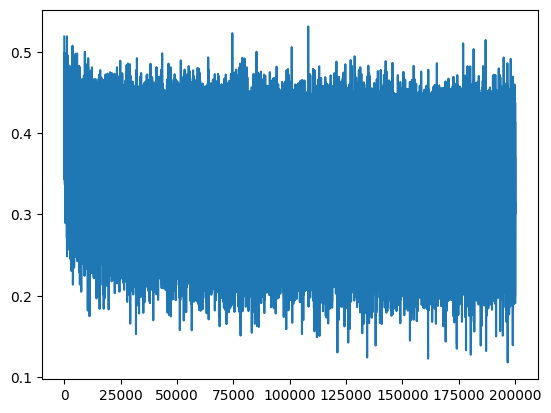

In [162]:
plt.plot(lossi)

In [163]:
with torch.no_grad():
    emb = C[x_train]
    embcat = emb.view(emb.size(0), -1)
    hpreact = embcat @ W1 + B1
    bnmean = hpreact.mean(0, keepdim= True)
    bnstd = hpreact.std(0, keepdim= True)

In [164]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (x_train, y_train),
        'val': (x_val, y_val),
        'test': (x_test, y_test)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.size(0), -1)
    hpreact = embcat @ W1 + B1
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')
    

train 2.1210100650787354
val 2.166093587875366


initial losses after changing the initialization
train 2.180690050125122
val 2.2376396656036377

loss after fixing tanh activation
train 2.1318764686584473
val 2.1838724613189697

After batch norm
train 2.126826286315918
val 2.1739890575408936

In [165]:
#Pytorchifying the code
n_embd = 10
n_hidden = 100
C = torch.randn(len(itos), n_embd)
layers = torch.nn.Sequential(
    torch.nn.Linear(n_embd * block_size, n_hidden),
    torch.nn.Tanh(),
    torch.nn.Linear(n_hidden, n_hidden),
    torch.nn.Tanh(),
    torch.nn.Linear(n_hidden, n_hidden),
    torch.nn.Tanh(),
    torch.nn.Linear(n_hidden, n_hidden),
    torch.nn.Tanh(),
    torch.nn.Linear(n_hidden, n_hidden),
    torch.nn.Tanh(),
    torch.nn.Linear(n_hidden, len(itos))
)

params = [C] + [p for layer in layers for p in layer.parameters()]
for p in params:
    p.requires_grad = True    